<a href="https://colab.research.google.com/github/vshalisko/GEE/blob/main/Colab/GDL_Landsat_ANN_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Uso de ANN para clasificacion de Landsat 8
* Versión con la estandarizaciíón de datos con StandardScaler
* Clasificación en tres clases (no-urbano, urbano, agua)

In [45]:
!pip install pyrsgis
from pyrsgis import raster, convert

Preparar el entorno

In [44]:
import random
import math, glob, time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, cohen_kappa_score
from google.colab import drive

random.seed(2)

Coneccion con Google Drive para almacenar archivos

In [46]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Lectura de datos en formato numpy

In [47]:
# Load the arrays as .npy files
array_feature_2015 = np.load('/content/drive/MyDrive/Colab Data/GDL_2015_feature_L8_6b.npy')
array_feature_2014 = np.load('/content/drive/MyDrive/Colab Data/GDL_2014_feature_L8_6b.npy')
array_feature_2020 = np.load('/content/drive/MyDrive/Colab Data/GDL_2020_feature_L8_6b.npy')
array_target_binary_2015 = np.load('/content/drive/MyDrive/Colab Data/GDL_2015_target_2class.npy')
array_target_2015 = np.load('/content/drive/MyDrive/Colab Data/GDL_2015_target_3class.npy')

Transformar datos para trabajo con ANN en Keras - Tensor Flow

In [48]:
def feature_transform(source_array):
    array_t = np.transpose(source_array, (2, 0, 1))
    print(array_t.shape)
    table_array = convert.array_to_table(array_t)
    print(table_array.shape)
    return table_array

In [49]:
x_features_2015 = feature_transform(array_feature_2015)
x_features_2014 = feature_transform(array_feature_2014)
x_features_2020 = feature_transform(array_feature_2020)
y_labels_2015 = feature_transform(array_target_2015)
y_labels_binary_2015 = feature_transform(array_target_binary_2015)

## codigo innecesario cuando se aplica estandarizacion StandardScaler
#y_labels_2015 = y_labels_2015 - 1
#x_features_2014 = x_features_2014 / 32768
#x_features_2015 = x_features_2015 / 32768
#x_features_2020 = x_features_2020 / 32768
nBands = x_features_2015.shape[1]

(6, 1834, 2070)
(3796380, 6)
(6, 1834, 2070)
(3796380, 6)
(6, 1834, 2070)
(3796380, 6)
(1, 1834, 2070)
(3796380, 1)
(1, 1834, 2070)
(3796380, 1)


Estandarización de datos

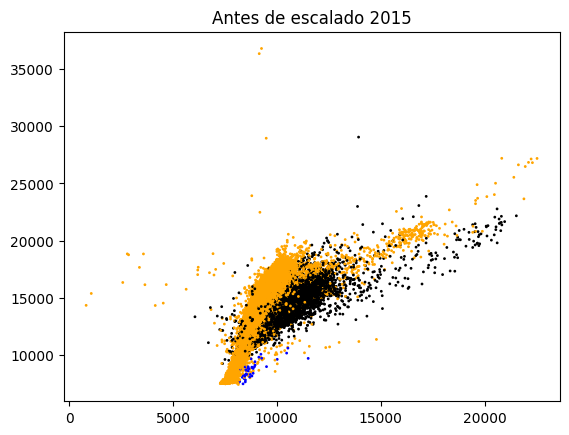

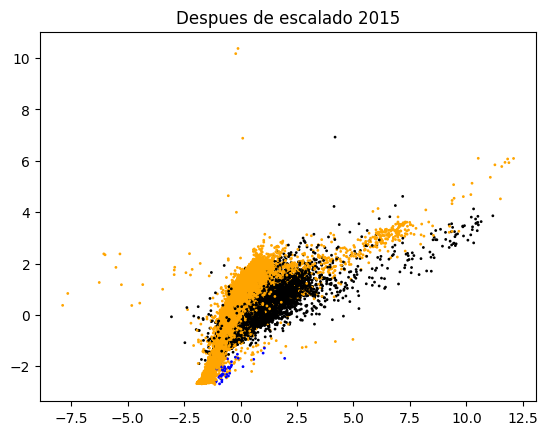

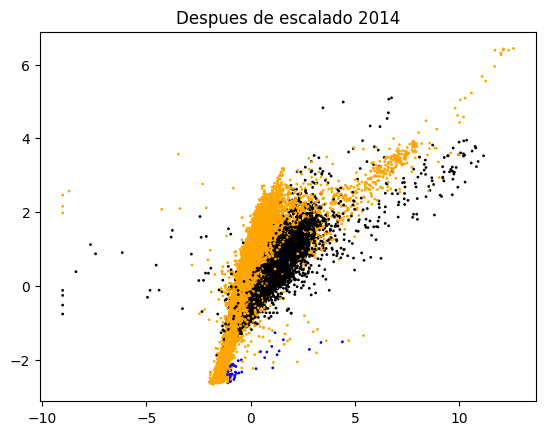

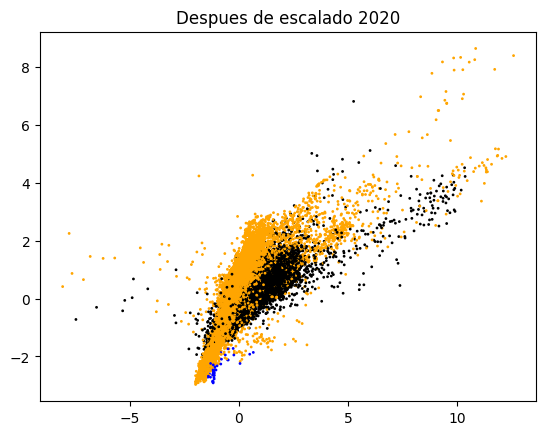

In [50]:
## visualización de la muestre de 50 k elementos
colors = ['orange', 'blue', 'black']
rango = slice(1000000,1050000)
colors_list = [colors[int(i) % 3] for i in y_labels_2015[rango,0]]

plt.scatter(x_features_2015[rango,0], x_features_2015[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Antes de escalado 2015')
plt.show()

scale = StandardScaler()
x_features_2014 = scale.fit_transform(x_features_2014)
x_features_2015 = scale.fit_transform(x_features_2015)
x_features_2020 = scale.fit_transform(x_features_2020)

plt.scatter(x_features_2015[rango,0], x_features_2015[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2015')
plt.show()

plt.scatter(x_features_2014[rango,0], x_features_2014[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2014')
plt.show()

plt.scatter(x_features_2020[rango,0], x_features_2020[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2020')
plt.show()

In [51]:
print(x_features_2015)
print(y_labels_2015)

[[-0.56036125 -0.83373913 -0.84875343 -1.29670839 -0.88645584 -0.75088024]
 [-0.57784197 -0.90195001 -0.87466271 -1.25955973 -0.76325186 -0.71837877]
 [-0.49319849 -0.8652775  -0.80557129 -1.12879644 -0.594474   -0.58659196]
 ...
 [-1.71960892 -1.96031882 -1.97033756 -3.28490482 -3.00255172 -2.62305428]
 [-1.68556752 -1.90164279 -1.89894309 -3.21853254 -2.90831419 -2.57452468]
 [-1.59356374 -1.83416536 -1.79069985 -3.11352566 -2.68662428 -2.40355802]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


Subdividir datos de entrenamiento y control (2015)

In [52]:
xTrain, xTest, yTrain, yTest = train_test_split(x_features_2015, y_labels_2015, test_size=0.4, random_state=242)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

print(xTrain)
print(yTrain)

# Reshape the data
xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))

print(xTrain.shape, xTest.shape)

(2277828, 6)
(2277828, 1)
(1518552, 6)
(1518552, 1)
[[ 0.00546202 -0.02841069 -0.01447447 -0.23475195  0.70245062  0.63688824]
 [ 1.28523465  1.17371438  1.35526303  0.99412581  1.37872072  1.48459796]
 [-1.34331345 -1.691876   -1.60645605 -2.39432755 -2.28765968 -1.88487009]
 ...
 [-0.14266407 -0.1758342  -0.10602061 -0.5557164   0.62095833  0.45657183]
 [ 0.83993633  0.8707994   0.63268188  0.23183525  0.19186862  0.95522461]
 [-0.74252874 -0.94008943 -0.87639    -1.36951977 -0.97644495 -0.75488728]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
(2277828, 1, 6) (1518552, 1, 6)


Entrenar la red neuronal (ANN) simple con 2 capas ocultas

In [53]:
from tensorflow import keras

# Define the parameters of the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(3, activation='softmax')])

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Run the model
model.fit(xTrain, yTrain, epochs=5)

Epoch 1/5
71183/71183 [==============================] - 163s 2ms/step - loss: 0.1646 - accuracy: 0.9397
Epoch 2/5
71183/71183 [==============================] - 155s 2ms/step - loss: 0.1555 - accuracy: 0.9417
Epoch 3/5
71183/71183 [==============================] - 154s 2ms/step - loss: 0.1541 - accuracy: 0.9423
Epoch 4/5
71183/71183 [==============================] - 148s 2ms/step - loss: 0.1534 - accuracy: 0.9425
Epoch 5/5
71183/71183 [==============================] - 148s 2ms/step - loss: 0.1529 - accuracy: 0.9427


In [73]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 6)                 0         
                                                                 
 dense_3 (Dense)             (None, 20)                140       
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 3)                 33        
                                                                 
Total params: 383 (1.50 KB)
Trainable params: 383 (1.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [54]:
model.save('/content/drive/MyDrive/Colab Data/GDL_2015_model_ANN_2hl_3class.tensorflow')

In [55]:
# Predict for test data
yTestPredicted_raw = model.predict(xTest)
yTestPredicted_class = yTestPredicted_raw.argmax(axis=-1)

47455/47455 [==============================] - 116s 2ms/step


In [57]:
#yTestPredicted = yTestPredicted_raw[:,:]

## Aplicable solo para clasificacion binaria
#roc_auc_raw = roc_auc_score(yTest, yTestPredicted)
#yTestPredicted = (yTestPredicted>0.5).astype(int)
#yTestPredicted = yTestPredicted.argmax(axis=1)
#roc_auc = roc_auc_score(yTest, yTestPredicted)

## Aplicable para clasificacion multiclase
cMatrix = confusion_matrix(yTest, yTestPredicted_class)
accuracy = accuracy_score(yTest, yTestPredicted_class)
kappa = cohen_kappa_score(yTest, yTestPredicted_class)
pScore = precision_score(yTest, yTestPredicted_class, average=None)
rScore = recall_score(yTest, yTestPredicted_class, average=None)
f1Score = f1_score(yTest, yTestPredicted_class, average=None)

print("Confusion matrix:\n", cMatrix)
print("\nExactitud (accuracy): %.3f," % accuracy)
print("\nKappa de Cohen: %.3f," % kappa)
#print("\nROC AUC raw: %.3f," % roc_auc_raw)
#print("\nROC AUC: %.3f," % roc_auc)
print("\nClase 1. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[0], rScore[0], f1Score[0]))
print("\nClase 2. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[1], rScore[1], f1Score[1]))
print("\nClase 3. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[2], rScore[2], f1Score[2]))

Confusion matrix:
 [[1194105     339   35878]
 [   2976    9950     172]
 [  47501       9  227622]]

Exactitud (accuracy): 0.943,

Kapa de Cohen: 0.812,

Clase 1. Selectividad (precision): 0.959, especificidad (recall): 0.971, f1: 0.965

Clase 2. Selectividad (precision): 0.966, especificidad (recall): 0.760, f1: 0.851

Clase 3. Selectividad (precision): 0.863, especificidad (recall): 0.827, f1: 0.845


Predicción para datos de 2015

In [58]:
x_features_2015_n = x_features_2015
x_features_2015_n = x_features_2015_n.reshape((x_features_2015_n.shape[0], 1, x_features_2015_n.shape[1]))

predicted_2015 = model.predict(x_features_2015_n)
print(predicted_2015)

118637/118637 [==============================] - 250s 2ms/step
[[9.9702555e-01 2.6434989e-04 2.7100630e-03]
 [9.9861246e-01 1.4359351e-04 1.2438621e-03]
 [9.9844480e-01 1.3794459e-04 1.4172732e-03]
 ...
 [9.9690151e-01 3.0432220e-03 5.5237459e-05]
 [9.9684513e-01 3.0931118e-03 6.1825660e-05]
 [9.9918848e-01 7.7187514e-04 3.9711547e-05]]


Vista de la superficie de 2015 con etiquetas categoricas de mayor probabilidad

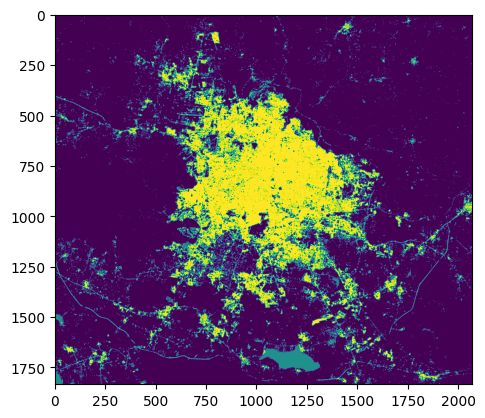

In [62]:
predicted_2015_class = predicted_2015.argmax(axis=-1)
predicted_2015_class_re = np.reshape(predicted_2015_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2015_class_re[:,:])
plt.show()

Superficie de probabilidad para clase urbano en 2015

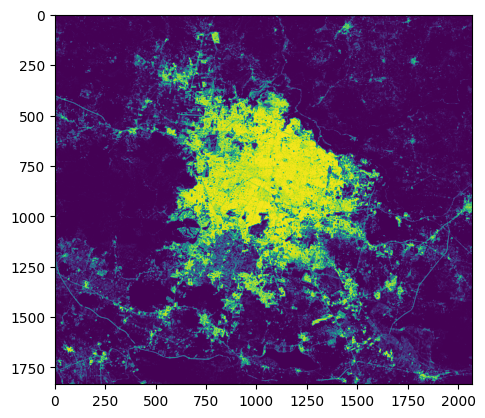

In [63]:
prediction_2015_urbano = np.reshape(predicted_2015[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2015 = (prediction_2015_urbano).astype('float')
plt.imshow(B_img_pred_2015[:,:])
plt.show()

Predicción para 2020

In [64]:
x_features_2020_n = x_features_2020
x_features_2020_n = x_features_2020_n.reshape((x_features_2020_n.shape[0], 1, x_features_2020_n.shape[1]))

predicted_2020 = model.predict(x_features_2020_n)
print(predicted_2020)

118637/118637 [==============================] - 235s 2ms/step
[[9.9914479e-01 1.4396742e-04 7.1124319e-04]
 [9.9927878e-01 1.2509283e-04 5.9606240e-04]
 [9.9912512e-01 1.2118329e-04 7.5366400e-04]
 ...
 [9.9938202e-01 4.9166422e-04 1.2629949e-04]
 [9.9961877e-01 3.1755579e-04 6.3587700e-05]
 [9.9957806e-01 3.6721307e-04 5.4647444e-05]]


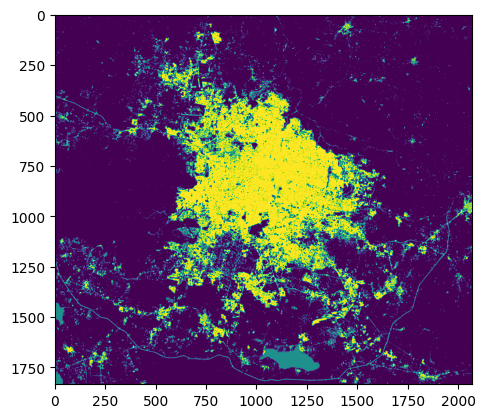

In [65]:
predicted_2020_class = predicted_2020.argmax(axis=-1)
predicted_2020_class_re = np.reshape(predicted_2020_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2020_class_re[:,:])
plt.show()

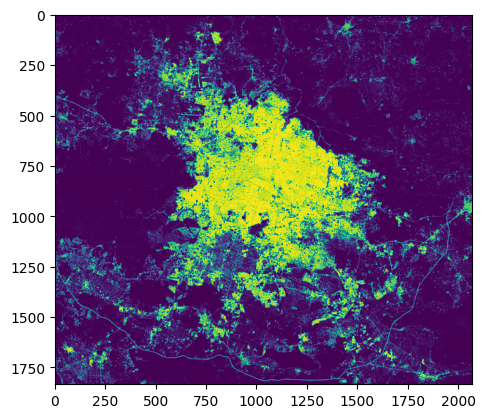

In [68]:
prediction_2020_urbano = np.reshape(predicted_2020[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2020 = (prediction_2020_urbano).astype('float')
plt.imshow(B_img_pred_2020[:,:])
plt.show()


Predicción para 2014

In [67]:
x_features_2014_n = x_features_2014
x_features_2014_n = x_features_2014_n.reshape((x_features_2014_n.shape[0], 1, x_features_2014_n.shape[1]))

predicted_2014 = model.predict(x_features_2014_n)
print(predicted_2014)

118637/118637 [==============================] - 269s 2ms/step
[[9.9805456e-01 2.1694944e-04 1.7285207e-03]
 [9.9612480e-01 3.0008928e-04 3.5751341e-03]
 [9.9791646e-01 1.6327873e-04 1.9201884e-03]
 ...
 [9.9262249e-01 7.2457162e-03 1.3176924e-04]
 [9.9347901e-01 6.3359803e-03 1.8494971e-04]
 [9.9852055e-01 1.3935678e-03 8.5992018e-05]]


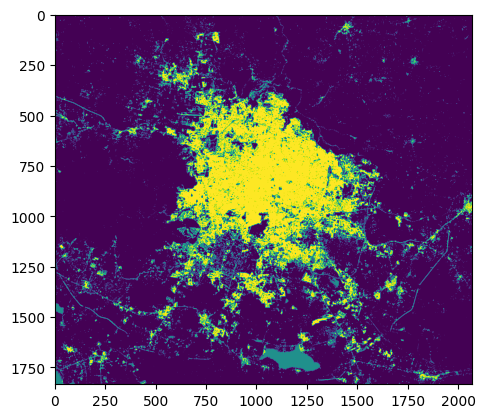

In [69]:
predicted_2014_class = predicted_2014.argmax(axis=-1)
predicted_2014_class_re = np.reshape(predicted_2014_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2014_class_re[:,:])
plt.show()

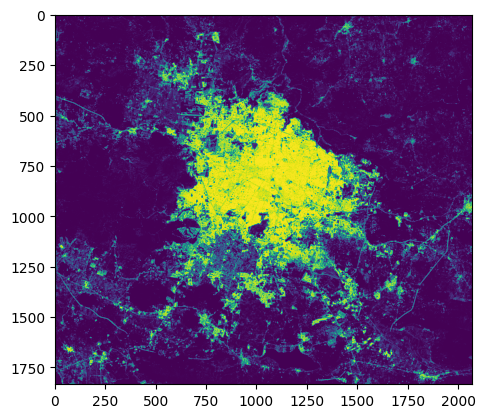

In [70]:
prediction_2014_urbano = np.reshape(predicted_2014[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2014 = (prediction_2014_urbano).astype('float')
plt.imshow(B_img_pred_2014[:,:])
plt.show()

Guardar capas numpy de prediccion

In [71]:
# Save the arrays as .npy files
np.save('/content/drive/MyDrive/Colab Data/GDL_2014_prediction_class.npy', predicted_2014_class)
np.save('/content/drive/MyDrive/Colab Data/GDL_2015_prediction_class.npy', predicted_2015_class)
np.save('/content/drive/MyDrive/Colab Data/GDL_2020_prediction_class.npy', predicted_2020_class)
np.save('/content/drive/MyDrive/Colab Data/GDL_2014_prediction_urbano_float.npy', prediction_2014_urbano)
np.save('/content/drive/MyDrive/Colab Data/GDL_2015_prediction_urbano_float.npy', prediction_2015_urbano)
np.save('/content/drive/MyDrive/Colab Data/GDL_2020_prediction_urbano_float.npy', prediction_2020_urbano)